# Risk-aware MCTS
#### Four-state MDP

In [27]:
import os
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

matplotlib.rcParams['text.usetex'] =  True
plt.rc('text.latex', preamble=r'\usepackage{pifont} \usepackage{amsfonts}')
matplotlib.rcParams.update({'font.size': 20})

sns.set_palette("colorblind")

In [28]:
def calculate_erm(dist, beta):
    return (1.0 / beta) * np.log( (1/len(dist)) * np.sum(np.exp(beta*dist)) )

In [29]:
def erm_ci(samples: np.ndarray, beta : float, num_resamples: int=25_000):
    # Confidence interval estimation.
    resampled = np.random.choice(samples,
                                size=(len(samples), num_resamples),
                                replace=True).T
    # print("resampled.shape", resampled.shape)
    erms = (1.0 / beta) * np.log((1/resampled.shape[1]) * np.sum(np.exp(beta*resampled), axis=1))
    confidence_interval = [np.percentile(erms, 5), np.percentile(erms, 95)]

    return confidence_interval

### Load experiments data

In [30]:
# np.sqrt(np.sqrt(Ns) / Na) bonus experiments.

['four_state_mdp_erm-mcts_gamma_0.9_beta_1.0_2026-01-30-14-00-440', 'four_state_mdp_erm-mcts_gamma_0.9_beta_1.0_2026-01-30-14-01-030', 'four_state_mdp_erm-mcts_gamma_0.9_beta_1.0_2026-01-30-14-01-500', 'four_state_mdp_acc-mcts_gamma_0.9_beta_1.0_2026-01-30-14-04-030', 'four_state_mdp_acc-mcts_gamma_0.9_beta_1.0_2026-01-30-14-04-210', 'four_state_mdp_acc-mcts_gamma_0.9_beta_1.0_2026-01-30-14-04-570']

erm_mcts_planner_paths = {
    # 0.01: {
    #    100: 'four_state_mdp_erm-mcts_gamma_0.9_beta_0.01_2026-01-30-13-27-570', # H=20
    #    200: 'four_state_mdp_erm-mcts_gamma_0.9_beta_0.01_2026-01-30-13-28-190', # H=20
    #    500: 'four_state_mdp_erm-mcts_gamma_0.9_beta_0.01_2026-01-30-13-29-030', # H=20    
    # },
    0.1: {
        100: 'four_state_mdp_erm-mcts_gamma_0.9_beta_0.1_2026-01-30-15-17-400', # H=20
        200: 'four_state_mdp_erm-mcts_gamma_0.9_beta_0.1_2026-01-30-15-18-010', # H=20
        500: 'four_state_mdp_erm-mcts_gamma_0.9_beta_0.1_2026-01-30-15-18-460', # H=20
        1_000: 'four_state_mdp_erm-mcts_gamma_0.9_beta_0.1_2026-02-01-15-02-040', # H=20
    },
    0.5: {
        100: 'four_state_mdp_erm-mcts_gamma_0.9_beta_0.5_2026-01-30-15-07-150', # H=20
        200: 'four_state_mdp_erm-mcts_gamma_0.9_beta_0.5_2026-01-30-15-07-380', # H=20
        500: 'four_state_mdp_erm-mcts_gamma_0.9_beta_0.5_2026-01-30-15-08-230', # H=20
        1_000: 'four_state_mdp_erm-mcts_gamma_0.9_beta_0.5_2026-02-01-15-12-520', # H=20
    },
    1.0: {
        100: 'four_state_mdp_erm-mcts_gamma_0.9_beta_1.0_2026-01-30-14-00-440', # H=20
        200: 'four_state_mdp_erm-mcts_gamma_0.9_beta_1.0_2026-01-30-14-01-030', # H=20
        500: 'four_state_mdp_erm-mcts_gamma_0.9_beta_1.0_2026-01-30-14-01-500', # H=20
        1_000: 'four_state_mdp_erm-mcts_gamma_0.9_beta_1.0_2026-02-01-15-23-240', # H=20
    },
    # 2.0: {
    #    100: 'four_state_mdp_erm-mcts_gamma_0.9_beta_2.0_2026-01-30-13-13-210', # H=20
    #    200: 'four_state_mdp_erm-mcts_gamma_0.9_beta_2.0_2026-01-30-13-13-390', # H=20
    #    500: 'four_state_mdp_erm-mcts_gamma_0.9_beta_2.0_2026-01-30-13-14-290', # H=20
    #    # 1_000: ''.
    #}
}
erm_mcts_planner_data = {}
for erm_beta in erm_mcts_planner_paths.keys():
    erm_mcts_planner_data[erm_beta] = {}
    for exp_step, mcts_path in erm_mcts_planner_paths[erm_beta].items():
        with open("data/" + mcts_path + "/exp_data.json", 'r') as f:
            data = json.load(f)
            data = json.loads(data)
        f.close()
        erm_mcts_planner_data[erm_beta][exp_step] = data
# print(erm_mcts_planner_data)

#######################################################################################
#######################################################################################
#######################################################################################
accrued_costs_mcts_planner_paths = {
    # 0.01: {
    #     100: 'four_state_mdp_acc-mcts_gamma_0.9_beta_0.01_2026-01-30-13-31-080',
    #     200: 'four_state_mdp_acc-mcts_gamma_0.9_beta_0.01_2026-01-30-13-31-250',
    #     500: 'four_state_mdp_acc-mcts_gamma_0.9_beta_0.01_2026-01-30-13-32-010',
    # },
    0.1: {
        100: 'four_state_mdp_acc-mcts_gamma_0.9_beta_0.1_2026-01-30-15-20-500', # H=20
        200: 'four_state_mdp_acc-mcts_gamma_0.9_beta_0.1_2026-01-30-15-21-080', # H=20
        500: 'four_state_mdp_acc-mcts_gamma_0.9_beta_0.1_2026-01-30-15-21-470', # H=20
        1_000: 'four_state_mdp_acc-mcts_gamma_0.9_beta_0.1_2026-02-01-15-07-000', # H=20
    },
    0.5: {
        100: 'four_state_mdp_acc-mcts_gamma_0.9_beta_0.5_2026-01-30-15-10-360', # H=20
        200: 'four_state_mdp_acc-mcts_gamma_0.9_beta_0.5_2026-01-30-15-10-520', # H=20
        500: 'four_state_mdp_acc-mcts_gamma_0.9_beta_0.5_2026-01-30-15-11-240', # H=20
        1_000: 'four_state_mdp_acc-mcts_gamma_0.9_beta_0.5_2026-02-01-15-17-400', # H=20
    },
    1.0: {
        100: 'four_state_mdp_acc-mcts_gamma_0.9_beta_1.0_2026-01-30-14-04-030', # H=20
        200: 'four_state_mdp_acc-mcts_gamma_0.9_beta_1.0_2026-01-30-14-04-210', # H=20
        500: 'four_state_mdp_acc-mcts_gamma_0.9_beta_1.0_2026-01-30-14-04-570', # H=20
        1_000: 'four_state_mdp_acc-mcts_gamma_0.9_beta_1.0_2026-02-01-15-28-470', # H=20
    },
    # 2.0: {
    #    100: 'four_state_mdp_acc-mcts_gamma_0.9_beta_2.0_2026-01-30-13-07-560',
    #    200: 'four_state_mdp_acc-mcts_gamma_0.9_beta_2.0_2026-01-30-13-08-110',
    #    500: 'four_state_mdp_acc-mcts_gamma_0.9_beta_2.0_2026-01-30-13-08-440',
    #}
}
accrued_costs_mcts_planner_data = {}
for erm_beta in erm_mcts_planner_paths.keys():
    accrued_costs_mcts_planner_data[erm_beta] = {}
    for exp_step, mcts_path in accrued_costs_mcts_planner_paths[erm_beta].items():
        # Load MCTS planner data and MDP.
        with open("data/" + mcts_path + "/exp_data.json", 'r') as f:
            data = json.load(f)
            data = json.loads(data)
        f.close()
        accrued_costs_mcts_planner_data[erm_beta][exp_step] = data
        print(erm_beta, exp_step, 'LENGTH:', len(data["f_vals"]))
# print(accrued_costs_mcts_planner_data)

#######################################################################################
#######################################################################################
#######################################################################################
erm_bi_paths = {
    # 0.01: 'four_state_mdp_erm-backward-induction_gamma_0.9_beta_0.01_2026-01-30-15-04-57', # H=20
    0.1: 'four_state_mdp_erm-backward-induction_gamma_0.9_beta_0.1_2026-01-30-15-05-25', # H=20
    0.5: "four_state_mdp_erm-backward-induction_gamma_0.9_beta_0.5_2026-01-30-15-05-37", # H=20
    1.0: "four_state_mdp_erm-backward-induction_gamma_0.9_beta_1.0_2026-01-30-15-05-55", # H=20
    # 2.0: "four_state_mdp_erm-backward-induction_gamma_0.9_beta_2.0_2026-01-30-15-06-08", # H=20
}
erm_bi_data = {}
for erm_beta, erm_bi_path in erm_bi_paths.items():
    # Load MCTS planner data and MDP.
    with open("data/" + erm_bi_path + "/exp_data.json", 'r') as f:
        data = json.load(f)
        data = json.loads(data)
    f.close()
    erm_bi_data[erm_beta] = data
# print(erm_bi_data)

0.1 100 LENGTH: 100
0.1 200 LENGTH: 100
0.1 500 LENGTH: 100
0.1 1000 LENGTH: 100
0.5 100 LENGTH: 100
0.5 200 LENGTH: 100
0.5 500 LENGTH: 100
0.5 1000 LENGTH: 100
1.0 100 LENGTH: 100
1.0 200 LENGTH: 100
1.0 500 LENGTH: 100
1.0 1000 LENGTH: 100


### Compare ERM's of the distribution of costs obtained by different algorithms

ERM-BI: 1.79 ; CI's: [1.760394513537902, 1.8160642021811846] ; CI's (lenghts): 0.03 0.03
Acc-MCTS: 1.77 ; CI's: [1.7425544247294218, 1.7917745213528584] ; CI's (lenghts): 0.02 0.02
ERM-MCTS: 1.83 ; CI's: [1.7919651467713662, 1.87124346336743] ; CI's (lenghts): 0.04 0.04


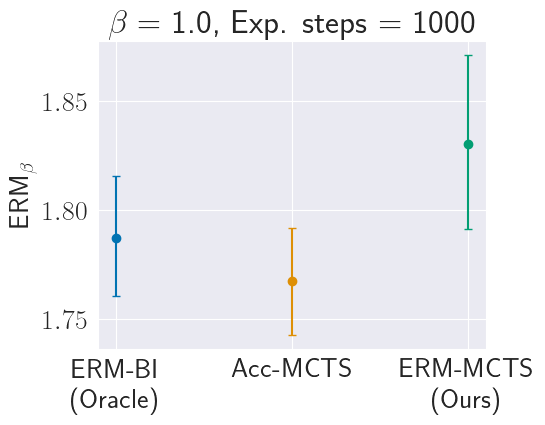

In [34]:
erm_beta_to_plot = 1.0
exp_steps_to_plot = 1_000

plt.figure(figsize=(5.0, 4.0))

# ERM-BI.
erm_val = calculate_erm(np.array(erm_bi_data[erm_beta_to_plot]["f_vals"]), beta=erm_beta_to_plot)
ci_up_length = erm_val - erm_ci(np.array(erm_bi_data[erm_beta_to_plot]["f_vals"]), beta=erm_beta_to_plot)[0]
ci_down_length = erm_ci(np.array(erm_bi_data[erm_beta_to_plot]["f_vals"]), beta=erm_beta_to_plot)[1] - erm_val
print("ERM-BI:", round(erm_val, 2), "; CI's:", erm_ci(np.array(erm_bi_data[erm_beta_to_plot]["f_vals"]), beta=erm_beta_to_plot), "; CI's (lenghts):", round(ci_up_length, 2), round(ci_down_length, 2))

# Accrued costs-MCTS.
erm_val = calculate_erm(np.array(accrued_costs_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot)
ci_up_length = erm_val - erm_ci(np.array(accrued_costs_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot)[0]
ci_down_length = erm_ci(np.array(accrued_costs_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot)[1] - erm_val
print("Acc-MCTS:", round(erm_val, 2), "; CI's:", erm_ci(np.array(accrued_costs_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot), "; CI's (lenghts):", round(ci_up_length, 2), round(ci_down_length, 2))

# ERM-MCTS.
erm_val = calculate_erm(np.array(erm_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot)
ci_up_length = erm_val - erm_ci(np.array(erm_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot)[0]
ci_down_length = erm_ci(np.array(erm_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot)[1] - erm_val
print("ERM-MCTS:", round(erm_val, 2), "; CI's:", erm_ci(np.array(erm_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot), "; CI's (lenghts):", round(ci_up_length, 2), round(ci_down_length, 2))

# ERM-BI.
erm_val = calculate_erm(np.array(erm_bi_data[erm_beta_to_plot]["f_vals"]), beta=erm_beta_to_plot)
cis = erm_ci(np.array(erm_bi_data[erm_beta_to_plot]["f_vals"]), beta=erm_beta_to_plot)
errors = np.array([erm_val - cis[0], cis[1] - erm_val]).reshape(-1,1)
plt.errorbar(1, erm_val, yerr=errors, capsize=3, fmt='o', label="ERM-BI")

# Acc-MCTS.
erm_val = calculate_erm(np.array(accrued_costs_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot)
cis = erm_ci(np.array(accrued_costs_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot)
errors = np.array([erm_val - cis[0], cis[1] - erm_val]).reshape(-1,1)
plt.errorbar(2, erm_val, yerr=errors, capsize=3, fmt='o', label="Acc-MCTS")

# ERM-MCTS.
erm_val = calculate_erm(np.array(erm_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot)
cis = erm_ci(np.array(erm_mcts_planner_data[erm_beta_to_plot][exp_steps_to_plot]["f_vals"]), beta=erm_beta_to_plot)
errors = np.array([erm_val - cis[0], cis[1] - erm_val]).reshape(-1,1)
plt.errorbar(3, erm_val, yerr=errors, capsize=3, fmt='o', label="ERM-MCTS")

# ax.set_ylim([-1.5,-0.2])
plt.xticks([1,2,3], ["ERM-BI\n(Oracle)", "Acc-MCTS", "ERM-MCTS\n(Ours)"])
plt.grid()
# plt.legend(loc=4)

plt.title(r'$\beta=$ ' + str(erm_beta_to_plot) + ", Exp. steps = " + str(exp_steps_to_plot))
plt.ylabel(r"ERM$_\beta$")

# os.makedirs("figs/", exist_ok=True)
# plt.savefig(f'figs/{mdp_name}_plot2.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

### Compare ERM's of the distribution of costs obtained by different algorithms (expansion steps)

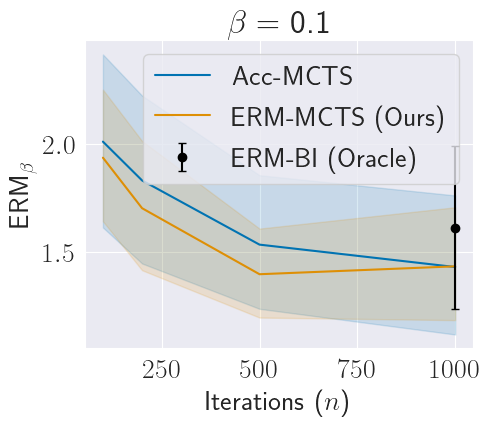

In [22]:
erm_beta_to_plot = 0.1
exp_steps_to_plot = [100, 200, 500, 1_000]

fig, ax = plt.subplots(figsize=(5.0, 4.0))

# Acc-MCTS
ys = []
cis = []
for exp_step in exp_steps_to_plot:
    ys.append(calculate_erm(np.array(accrued_costs_mcts_planner_data[erm_beta_to_plot][exp_step]["f_vals"]), beta=erm_beta_to_plot))
    cis.append(np.array(erm_ci(np.array(accrued_costs_mcts_planner_data[erm_beta_to_plot][exp_step]["f_vals"]), beta=erm_beta_to_plot)))
p = plt.plot(exp_steps_to_plot, ys, label="Acc-MCTS")
cis = np.array(cis)
plt.fill_between(exp_steps_to_plot, cis[:,0], cis[:,1], color=p[0].get_color(), alpha=0.15)

# ERM-MCTS
ys = []
cis = []
for exp_step in exp_steps_to_plot:
    ys.append(calculate_erm(np.array(erm_mcts_planner_data[erm_beta_to_plot][exp_step]["f_vals"]), beta=erm_beta_to_plot))
    cis.append(np.array(erm_ci(np.array(erm_mcts_planner_data[erm_beta_to_plot][exp_step]["f_vals"]), beta=erm_beta_to_plot)))
p = plt.plot(exp_steps_to_plot, ys, label="ERM-MCTS (Ours)")
cis = np.array(cis)
plt.fill_between(exp_steps_to_plot, cis[:,0], cis[:,1], color=p[0].get_color(), alpha=0.15)

# ERM-BI
erm_val = calculate_erm(np.array(erm_bi_data[erm_beta_to_plot]["f_vals"]), beta=erm_beta_to_plot)
cis = erm_ci(np.array(erm_bi_data[erm_beta_to_plot]["f_vals"]), beta=erm_beta_to_plot)
errors = np.array([erm_val - cis[0], cis[1] - erm_val]).reshape(-1,1)
plt.errorbar(1_000, erm_val, yerr=errors, capsize=3, fmt='o', label="ERM-BI (Oracle)",c='black')

# ax.set_ylim([-1.5,-0.2])
plt.grid()
plt.legend(loc=1)

plt.title(r'$\beta=$ ' + str(erm_beta_to_plot))
plt.ylabel(r"ERM$_{\beta}$")

plt.xlabel(r"Iterations ($n$)")

os.makedirs("figs/", exist_ok=True)
plt.savefig(f'figs/mdp-4-exp-steps-beta-{erm_beta_to_plot}.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

# Code to save the legend only.
#label_params = ax.get_legend_handles_labels() 
#figl, axl = plt.subplots()
#axl.axis(False)
#axl.legend(*label_params, loc="center", bbox_to_anchor=(0.5, 0.5), prop={"size":50}, ncols=3)
#os.makedirs("figs/", exist_ok=True)
#plt.savefig(f'figs/legend.pdf', bbox_inches='tight', pad_inches=0)

### Distribution of costs obtained by different algorithms

In [16]:
exp_steps_to_plot = 1_000

ERM-BI:

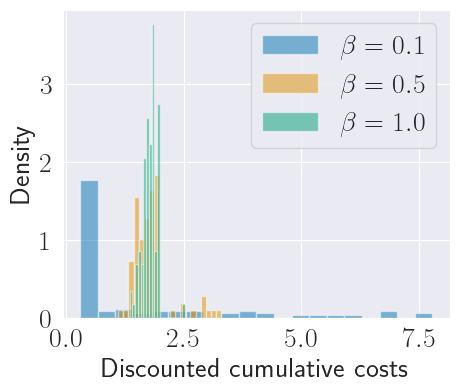

In [18]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

plt.hist(erm_bi_data[0.1]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$\beta=0.1$')
plt.hist(erm_bi_data[0.5]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$\beta=0.5$')
plt.hist(erm_bi_data[1.0]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$\beta=1.0$')
plt.ylabel('Density')
plt.xlabel("Discounted cumulative costs")
plt.grid()

plt.legend()
plt.show()

Accrued costs MCTS:

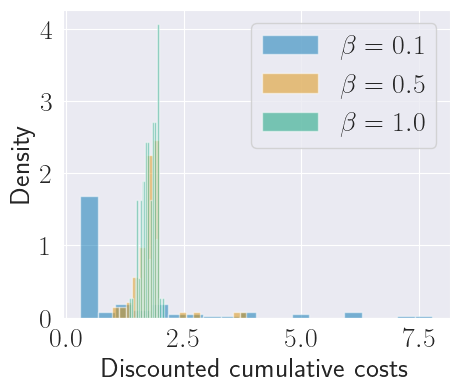

In [19]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

plt.hist(accrued_costs_mcts_planner_data[0.1][exp_steps_to_plot]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$\beta=0.1$')
plt.hist(accrued_costs_mcts_planner_data[0.5][exp_steps_to_plot]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$\beta=0.5$')
plt.hist(accrued_costs_mcts_planner_data[1.0][exp_steps_to_plot]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$\beta=1.0$')
plt.ylabel('Density')
plt.xlabel("Discounted cumulative costs")
plt.grid()

plt.legend()
plt.show()

ERM-MCTS:

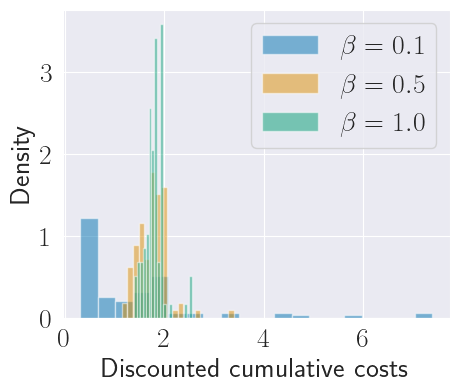

In [20]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

plt.hist(erm_mcts_planner_data[0.1][exp_steps_to_plot]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$\beta=0.1$')
plt.hist(erm_mcts_planner_data[0.5][exp_steps_to_plot]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$\beta=0.5$')
plt.hist(erm_mcts_planner_data[1.0][exp_steps_to_plot]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$\beta=1.0$')
plt.ylabel('Density')
plt.xlabel("Discounted cumulative costs")
plt.grid()

plt.legend()
# plt.show()

os.makedirs("figs/", exist_ok=True)
plt.savefig(f'figs/mdp-4-erm-mcts-costs-dists.pdf', bbox_inches='tight', pad_inches=0)

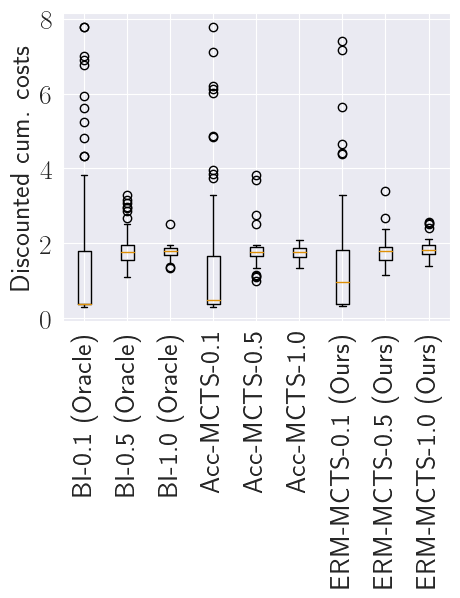

In [26]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

labels = []
data_to_plot = []
positions = [0,1,2]
for erm_beta, d in erm_bi_data.items():
    data_to_plot.append(d["f_vals"])
plt.boxplot(data_to_plot, positions=positions)
labels.extend(["BI-0.1 (Oracle)", "BI-0.5 (Oracle)", "BI-1.0 (Oracle)"])

data_to_plot = []
positions = [3,4,5]
for erm_beta, d in accrued_costs_mcts_planner_data.items():
    data_to_plot.append(d[exp_steps_to_plot]["f_vals"])
plt.boxplot(data_to_plot, positions=positions)
labels.extend(["Acc-MCTS-0.1", "Acc-MCTS-0.5", "Acc-MCTS-1.0"])

data_to_plot = []
positions = [6,7,8]
for erm_beta, d in erm_mcts_planner_data.items():
    data_to_plot.append(d[exp_steps_to_plot]["f_vals"])
plt.boxplot(data_to_plot, positions=positions)
labels.extend(["ERM-MCTS-0.1 (Ours)", "ERM-MCTS-0.5 (Ours)", "ERM-MCTS-1.0 (Ours)"])

# plt.ylabel('Density')
plt.ylabel("Discounted cum. costs");
plt.grid()
plt.xticks(range(len(labels)), labels)

plt.xticks(rotation=90)

# plt.title(r'$f(d) = d^\top \log(d)$')
plt.savefig("figs/mdp-4-distributions-comparison.pdf", bbox_inches='tight')
plt.show()